In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam, Optimizer
import keras2.backend as K
import tensorflow as tf
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2, selfDDPGAgent3
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Pendulum-v2')

In [19]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def value_net(s_shape):
    state_input = Input((1,)+s_shape)
    x = Flatten()(state_input)
    
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation="linear")(x)
    value = Model(inputs=state_input, output=x)
    return value

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

In [46]:
alpha = 0.1
beta = .5

dummy_optimizer = Optimizer()

def gradient_old(state, next_state, actor, critic):
    params = actor.trainable_weights
    
    # q_func gradient tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    gradient_for_q = dummy_optimizer.get_gradients(loss, params)
    
    # discount factor gradient tensor
    discount = - tf.exp(- alpha * actor_output[0][1])
    gradient_for_d = dummy_optimizer.get_gradients(discount, params)
    next_state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    next_action = actor(next_state_input)
    next_value = critic([next_action, next_state_input])[0][0]
    gradient_for_d = [next_value * g for g in gradient_for_d]
    
    # gradient
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    
    # calc
    grad_calc_func = K.function([state_input, next_state_input], gradient_tensor)
    q_g = grad_calc_func([[state], [next_state]]) # ここに0.5sくらいかかる

    return q_g


def gradient_function(actor, critic):
    params = actor.trainable_weights
    # placeholder
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    ts_input = tf.placeholder(tf.float32, shape=(None, 1))
    values_input = tf.placeholder(tf.float32, shape=(None, 1))
    
    # q_func gradient tensor
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    obj1 = tf.multiply(K.exp(- alpha * ts_input), critic_output_tensor)
    loss1 = -K.sum(obj1)
    gradient_for_q = dummy_optimizer.get_gradients(loss1, params)
    
    # discount factor gradient tensor
    discount = tf.expand_dims(- tf.exp(- alpha * actor_output[:,1]), 1)
    weights = tf.multiply(K.exp(- alpha * ts_input), values_input) # param勾配ないならok
    obj2 = tf.multiply(weights, discount)
    loss2 = K.sum(obj2)
    gradient_for_d = dummy_optimizer.get_gradients(loss2, params)
    
    gradient_tensor = [K.add(gq, gd) for gq, gd in zip(gradient_for_q, gradient_for_d)]
    func = K.function([state_input, ts_input, values_input], gradient_tensor)
    
    return func

def gradient(states, ts, values, gradient_func):
    gradient = gradient_func([states, ts, values])
    return gradient


# Adam クラス
def learning_rate_arr(actor, size=210, u_lr=.00001, tau_lr=.0001):
    grad_idx = 0
    i, j = 0, 0
    lrs = np.zeros((size,))
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            grad_idx += len(w.ravel()) + len(b.ravel())
            if j % 2 == 0: # u
                lrs[i:grad_idx] = u_lr
            else: # tau
                lrs[i:grad_idx] = tau_lr
            i = grad_idx
            j += 1
    return lrs

    
def flatten_gradient(gradient):
    params = []
    for i in range(len(gradient)//2):
        w, b = gradient[2*i], gradient[2*i+1]
        layer_params = np.hstack((w.ravel(), b.ravel()))
        params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params


def get_nn_params(actor):
    params = []
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            layer_params = np.hstack((w.ravel(), b.ravel()))
            params = np.hstack((params, layer_params))
    params = np.array(params).ravel()
    return params

def set_nn_params(actor, params):
    param_idx = 0
    for layer in actor.layers:
        if len(layer.get_weights())==0:
            continue
        else:
            w, b = layer.get_weights()
            # set w
            w_prime = params[param_idx:param_idx+w.ravel().shape[0]].reshape(w.shape)
            param_idx += w.ravel().shape[0]

            # set b
            b_prime = params[param_idx:param_idx+b.ravel().shape[0]].reshape(b.shape)
            param_idx += b.ravel().shape[0]

            layer.set_weights([w_prime, b_prime])
    assert params.shape[0] == param_idx
    return actor

class Adam_original():
    def __init__(self, lrs, beta_1=.9, beta_2=.999, epsilon=1e-6):
        self.lrs = lrs # 学習率
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        self.m = np.zeros(210,) # 前回の勾配
        self.v = np.zeros(210,) # 前回の2乗勾配
    
    def update(self, actor, pg):
        # update m
        self.m = (self.beta_1 * self.m) + (1. - self.beta_1) * pg
        
        # update v
        self.v = (self.beta_2 * self.v) + (1. - self.beta_2) * pg**2
        
        # 更新量を決める
        ag = self.lrs * self.m / (np.sqrt(self.v) + self.epsilon)
        
        # 今のパラメータ
        ps = get_nn_params(actor)
        
        # update
        ps = ps - ag
        
        # update
        actor = set_nn_params(actor, ps)
    
        return actor

In [47]:
# 1ステップインタラクション
def interaction(state, u, tau, env, ln=0):
    env.reset()
    x = np.array(state)
    env.set_state(x)
    reward = 0
    a_agent, tau = u, tau
    tau = np.clip(tau, 0.01, 10.)
    action_repetition = int(np.ceil(100 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = .01
    for p in range(action_repetition):
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    state1 = env.state
    return reward, state1


# 学習データ
def train_data(actor, noise=False):
    memory = []
    S1 = np.linspace(-7, 7, 10)
    S2 = np.linspace(-7, 7, 10)
    S1, S2 = np.meshgrid(S1, S2)
    S1, S2 = S1.flatten(), S2.flatten()
    
    ln = 1 if noise else 0
    n = 5 if noise else 1
    
    for _ in range(n):
        for i, x in enumerate(zip(S1, S2)):
            state0 = np.array(x)
            noise = np.array([np.random.randn() / 10., np.random.randn() / 10.])
            a_agent, tau = actor.predict_on_batch(state0.reshape((1,1,)+state0.shape))[0] + ln*noise
            reward, state1 = interaction(state0, a_agent, tau, env, ln=0.1)
            memory.append([state0, np.array([a_agent, tau]), reward, state1])
    memory = np.array(memory)
    return memory

# Q関数の学習
def td_learning(memory, actor, critic, target_actor, target_critic, batch_size=32, epoch=5000):
    # TODO: loss小さい=関数として正しい　をチェックする
    assert critic.compile, 'compile critic before use this function'
    # critic learning
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = target_actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        target = target_critic.predict_on_batch(state1_batch_with_action)
        discount = np.exp(- alpha * action_batch[:,1].reshape(batch_size, 1))
        r_second = np.multiply(discount, target)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        
        losses.append(loss)
        
    return critic, losses

# 勾配の計算
def reshape_data(data, mode=0):
    tmp = []
    for d in data:
        tmp.append(d)
    if mode==0:
        return np.array(tmp).reshape(len(data), 1, d.shape[0])
    else:
        return np.array(tmp).reshape(len(data), d.shape[0])
def policy_gradient(actor, critic, init_state = np.array([1,2])):
    # 初期状態からのシミュレーション
    x = init_state
    episode_time = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.1)
        episode_time += tau
        if episode_time >= 20.:
            log.append([x, episode_time])
            break
    
    # Q 関数の勾配を計算する
    '''
    pg = 0
    # Q 関数の勾配を計算する
    for x, t in log:
        g = q_gradient([x], actor, critic)
        g = flatten_gradient(g)
        g *= np.exp(- alpha * t)
        pg += g
    '''
    log = np.array(log)
    nvs = []
    #next value
    for i in range(1,len(log)):
        ns = log[i][0]
        na = actor.predict_on_batch(ns.reshape(1,1,2))
        nv = critic.predict_on_batch([na, ns.reshape(1,1,2)])[0]
        nvs.append(nv)

    pg = func([reshape_data(log[:-1,0]), log[:-1,1], nvs])
    return flatten_gradient(pg)

def update_target_model(model, target_model, l=0.01):
    p = l * get_nn_params(model) + (1 - l) * get_nn_params(target_model)
    target_model = set_nn_params(target_model, p)
    return target_model

def clone_model(model, target_model):
    params = get_nn_params(model)
    target_model = set_nn_params(target_model, params)
    return target_model


# 評価
def evaluation(actor, init_state = np.array([1,2])):
    x = init_state
    episode_time = 0
    episode_reward = 0
    log = []
    while True:
        a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
        log.append([x, episode_time])
        reward, x = interaction(x, a_agent, tau, env, ln=0.)
        episode_reward += np.exp(- alpha * episode_time) * reward
        episode_time += tau
        if episode_time >= 30.:
            log.append([x, episode_time])
            break
    return episode_reward


In [48]:
actor = branch_actor((2,),(2,))
critic = critic_net((2,),(2,))[0]
target_actor = branch_actor((2,),(2,))
target_critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
target_critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
func = gradient_function(actor, critic)

In [49]:
actor.load_weights('../saved_agent/learned_self_clipped_actor.h5')
critic.load_weights('../saved_agent/learned_self_clipped_critic_l.h5')
target_actor = clone_model(actor, target_actor)
target_critic = clone_model(critic, target_critic)
lrs = learning_rate_arr(actor, size=210, u_lr=.00001, tau_lr=.0001)
opt = Adam_original(lrs)
ev = evaluation(actor)

In [50]:
ev_log = [ev]
print(f'value_function for initial policy = {ev}')
for i in range(1, 100):
    d_train = train_data(actor, noise=True)
    cand, losses = td_learning(d_train, actor, critic, target_actor, target_critic, epoch=int(5000//(np.sqrt(i))))
    if np.mean(losses) > 5:
        critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic)
    else:
        critic = cand
    pg = policy_gradient(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    ev = evaluation(actor)
    ev_log.append(ev)
    print(f'{i}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -14.651553315520339
1-step
loss of critic is 2.142657518386841, value_fuction V(s) = -14.638303754593359
|g| = 46097.930567126336
2-step
loss of critic is 1.8656234741210938, value_fuction V(s) = -14.623004421267291
|g| = 17946.17890974285
3-step
loss of critic is 1.5892926454544067, value_fuction V(s) = -14.623712343289512
|g| = 17429.614650952975
4-step
loss of critic is 1.4970296621322632, value_fuction V(s) = -14.603425605022133
|g| = 15018.783532576934
5-step
loss of critic is 1.402396321296692, value_fuction V(s) = -14.576791791242718
|g| = 17873.70277841728
6-step
loss of critic is 1.52303946018219, value_fuction V(s) = -14.554656215856296
|g| = 33954.66267454404
7-step
loss of critic is 1.37869393825531, value_fuction V(s) = -14.52446905395076
|g| = 25431.76893861288
8-step
loss of critic is 1.188572883605957, value_fuction V(s) = -14.512288573872288
|g| = 24350.222280902206
9-step
loss of critic is 1.166447401046753, value_fuction V(s) = -14

KeyboardInterrupt: 

In [55]:
ev_log = [ev]
print(f'value_function for initial policy = {ev}')
for i in range(41, 100):
    d_train = train_data(actor, noise=True)
    cand, losses = td_learning(d_train, actor, critic, target_actor, target_critic, epoch=int(5000//(np.sqrt(i))))
    if np.mean(losses) > 5:
        critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic)
    else:
        critic = cand
    pg = policy_gradient(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    ev = evaluation(actor)
    ev_log.append(ev)
    print(f'{i}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -13.025863767436002
41-step
loss of critic is 1.531071424484253, value_fuction V(s) = -12.991493540175854
|g| = 64638.00247511189
42-step
loss of critic is 1.42034113407135, value_fuction V(s) = -12.938591055566453
|g| = 56044.893605911406
43-step
loss of critic is 1.512048602104187, value_fuction V(s) = -12.920457933382519
|g| = 53578.056702491434
44-step
loss of critic is 1.8237154483795166, value_fuction V(s) = -12.892172321296892
|g| = 71592.36167090495
45-step
loss of critic is 1.6919710636138916, value_fuction V(s) = -12.871718469392892
|g| = 67699.49866912271
46-step
loss of critic is 1.8409439325332642, value_fuction V(s) = -12.82940225805274
|g| = 79060.29041251546
47-step
loss of critic is 1.5792977809906006, value_fuction V(s) = -12.8142043294253
|g| = 78222.56684718098
48-step
loss of critic is 1.6785659790039062, value_fuction V(s) = -12.797577513847827
|g| = 78126.85920931066
49-step
loss of critic is 1.6707843542099, value_fuction V(s)

KeyboardInterrupt: 

In [64]:
ev_log = [ev]
print(f'value_function for initial policy = {ev}')
for i in range(61, 100):
    d_train = train_data(actor, noise=True)
    cand, losses = td_learning(d_train, actor, critic, target_actor, target_critic, epoch=int(5000//(np.sqrt(i))))
    if np.mean(losses) > 5:
        critic, losses = td_learning(d_train, actor, critic, target_actor, target_critic)
    else:
        critic = cand
    pg = policy_gradient(actor, critic)
    actor = opt.update(actor, pg/np.linalg.norm(pg))
    target_actor = update_target_model(actor, target_actor)
    target_critic = update_target_model(critic, target_critic)
    ev = evaluation(actor)
    ev_log.append(ev)
    print(f'{i}-step')
    print(f'loss of critic is {np.mean(losses)}, value_fuction V(s) = {ev}')
    print(f'|g| = {np.linalg.norm(pg)}')

value_function for initial policy = -15.636137391453275
61-step
loss of critic is 2.0357584953308105, value_fuction V(s) = -15.850197064583543
|g| = 51448.74435057375
62-step
loss of critic is 1.8672521114349365, value_fuction V(s) = -16.041869053393533
|g| = 57244.409684037186
63-step
loss of critic is 2.0023672580718994, value_fuction V(s) = -16.26495939611294
|g| = 46359.95071158835
64-step
loss of critic is 2.078094959259033, value_fuction V(s) = -16.45033321993376
|g| = 41935.234724298316
65-step
loss of critic is 1.8215068578720093, value_fuction V(s) = -12.34637159141281
|g| = 58219.45296004947
66-step
loss of critic is 2.100456953048706, value_fuction V(s) = -12.348500032630287
|g| = 25643.726285247096
67-step
loss of critic is 2.1664273738861084, value_fuction V(s) = -12.352659782648784
|g| = 54719.31746852492
68-step
loss of critic is 2.6064093112945557, value_fuction V(s) = -12.35753536677531
|g| = 55448.244211104946
69-step
loss of critic is 2.24428129196167, value_fuction 

In [67]:
env.reset()
#actor.load_weights('../saved_agent/learned_self_clipped_actor.h5')
initial_state = np.array([1., 2.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    tau = np.clip(tau, .01, 10.)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=0.1)
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
        r *= np.exp(- alpha * p * dt)
        reward += r
    reward *= dt
    reward -= beta
    states.append(env.state)
    episode_reward += np.exp(- alpha * acc_time) * reward
    acc_time += tau
    time_log.append(acc_time)
    if acc_time > time_limit:
        break
action_log.append(actor.predict_on_batch(env.state.reshape(1,1,2))[0][0])
states = np.array(states)
detail_states = np.array(detail_states)

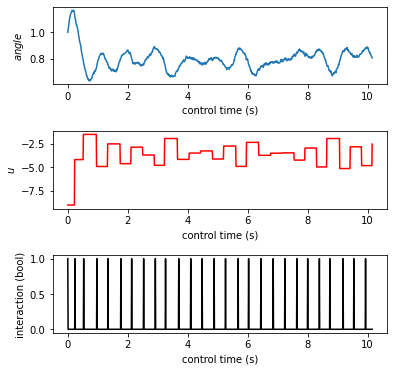

In [68]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$angle$')
plt.plot(detail_time_log, detail_states[:,0])
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [62]:
episode_reward

-10.241624992580725

In [63]:
actor.save_weights('../saved_agent/learned_self_ideal2_actor.h5')
critic.save_weights('../saved_agent/learned_self_ideal2_critic.h5')

In [36]:
# 逆にいうたらここからあれが学習できてるのすごくね

In [39]:
sr = '''
value_function for initial policy = -14.651553315520339
1-step
loss of critic is 2.453906297683716, value_fuction V(s) = -14.64020273675123
|g| = 25280.8685460266
2-step
loss of critic is 1.575911045074463, value_fuction V(s) = -14.626490920382267
|g| = 33455.21600632259
3-step
loss of critic is 1.435912013053894, value_fuction V(s) = -14.627907081950548
|g| = 14683.031441122717
4-step
loss of critic is 1.277782678604126, value_fuction V(s) = -14.610944746121536
|g| = 10912.012936649551
5-step
loss of critic is 1.1043428182601929, value_fuction V(s) = -14.593401917367245
|g| = 16847.63264259075
6-step
loss of critic is 1.1931475400924683, value_fuction V(s) = -14.579809351453848
|g| = 28765.67136172031
7-step
loss of critic is 1.2112040519714355, value_fuction V(s) = -14.587249958244882
|g| = 4763.849217963635
8-step
loss of critic is 0.970130205154419, value_fuction V(s) = -14.572538717049902
|g| = 20215.840168199287
9-step
loss of critic is 1.0111092329025269, value_fuction V(s) = -14.552269441178696
|g| = 7529.378302264111
10-step
loss of critic is 1.103527307510376, value_fuction V(s) = -14.547672550873248
|g| = 6106.721253634963
11-step
loss of critic is 0.8830776810646057, value_fuction V(s) = -14.522015016516333
|g| = 12496.816415970574
12-step
loss of critic is 0.9252831339836121, value_fuction V(s) = -14.487754578853623
|g| = 13367.7115426584
13-step
loss of critic is 0.7622573375701904, value_fuction V(s) = -14.474472998388553
|g| = 6435.643153685086
14-step
loss of critic is 0.827085018157959, value_fuction V(s) = -14.423760979308355
|g| = 9653.977416391852
15-step
loss of critic is 1.0849411487579346, value_fuction V(s) = -14.363666953641658
|g| = 4680.419885002108
16-step
loss of critic is 0.9303029179573059, value_fuction V(s) = -14.317428391673866
|g| = 27919.355957705222
17-step
loss of critic is 1.0512614250183105, value_fuction V(s) = -14.246551808783618
|g| = 25196.81147068819
18-step
loss of critic is 0.9064823389053345, value_fuction V(s) = -14.206455182674292
|g| = 14338.250618714781
19-step
loss of critic is 0.7674578428268433, value_fuction V(s) = -14.157663620905906
|g| = 20965.20533176832
20-step
loss of critic is 0.7975500822067261, value_fuction V(s) = -14.085971733151554
|g| = 10827.692871677538
21-step
loss of critic is 0.7569666504859924, value_fuction V(s) = -14.045915652813115
|g| = 20291.82573586907
22-step
loss of critic is 0.7678369283676147, value_fuction V(s) = -13.969276282223793
|g| = 19355.400295693875
23-step
loss of critic is 0.6881107091903687, value_fuction V(s) = -13.91772248578423
|g| = 14850.530011726285
24-step
loss of critic is 0.7144360542297363, value_fuction V(s) = -13.854115497941116
|g| = 7038.52042202485
25-step
loss of critic is 0.6637290120124817, value_fuction V(s) = -13.79580903807974
|g| = 10708.689993307333
26-step
loss of critic is 0.7395850419998169, value_fuction V(s) = -13.741586766561447
|g| = 14896.839838632155
27-step
loss of critic is 0.7812700867652893, value_fuction V(s) = -13.673031386949324
|g| = 17944.62406047313
28-step
loss of critic is 0.7904548048973083, value_fuction V(s) = -13.596486279074375
|g| = 13072.471260166003
29-step
loss of critic is 0.7239544987678528, value_fuction V(s) = -13.577612866177809
|g| = 16243.4687465764
30-step
loss of critic is 0.7218506336212158, value_fuction V(s) = -13.496018174281906
|g| = 16091.859497330413
31-step
loss of critic is 0.8017226457595825, value_fuction V(s) = -13.440903536064475
|g| = 18818.606118324107
32-step
loss of critic is 0.7669045925140381, value_fuction V(s) = -13.364146967556408
|g| = 13395.331926913794
33-step
loss of critic is 0.5823352932929993, value_fuction V(s) = -13.348307917437268
|g| = 15899.722185468636
34-step
loss of critic is 0.679290235042572, value_fuction V(s) = -13.270083978625056
|g| = 10895.191261171749
35-step
loss of critic is 0.8274874091148376, value_fuction V(s) = -13.220023996187091
|g| = 11749.531312298097
36-step
loss of critic is 0.8456642627716064, value_fuction V(s) = -13.144354122838504
|g| = 9760.436122903044
37-step
loss of critic is 0.7768800258636475, value_fuction V(s) = -13.134043018349379
|g| = 12918.44179937536
38-step
loss of critic is 0.7608029842376709, value_fuction V(s) = -13.063782232376234
|g| = 22753.39208573002
39-step
loss of critic is 0.6984662413597107, value_fuction V(s) = -13.020467567925488
|g| = 14784.98038137281
40-step
loss of critic is 0.6810926198959351, value_fuction V(s) = -12.950027604562013
|g| = 16853.78811232828
41-step
loss of critic is 0.8145704865455627, value_fuction V(s) = -12.92690794006383
|g| = 21101.7698891701
42-step
loss of critic is 0.6737492084503174, value_fuction V(s) = -12.924642281448854
|g| = 14008.239722227258
43-step
loss of critic is 0.7845246195793152, value_fuction V(s) = -12.87296543709243
|g| = 15753.891933399827
44-step
loss of critic is 0.6739580035209656, value_fuction V(s) = -12.846026779239237
|g| = 13287.199527445837
45-step
loss of critic is 0.6998922824859619, value_fuction V(s) = -12.837608901597095
|g| = 15826.581079021369
46-step
loss of critic is 0.6679642200469971, value_fuction V(s) = -12.794042872196112
|g| = 18924.928247468764
47-step
loss of critic is 0.7366520762443542, value_fuction V(s) = -12.775510803232361
|g| = 22339.54485538229
48-step
loss of critic is 0.7945978045463562, value_fuction V(s) = -12.77622377006814
|g| = 20809.034986993818
49-step
loss of critic is 0.7783252000808716, value_fuction V(s) = -12.73542867826827
|g| = 32219.16311270367
50-step
loss of critic is 0.7945425510406494, value_fuction V(s) = -12.73385312669381
|g| = 30020.864988881203
51-step
loss of critic is 0.6653670072555542, value_fuction V(s) = -12.735912613036021
|g| = 30508.200264290175

'''

In [40]:
l = []
rs = []
for s in sr:
    if s != '\n':
        l.append(s)
    else:
        if len(l) > 30:
            #print(''.join([k for k in l[-19:] if k != '=']), len(l))
            rs.append(float(''.join([k for k in l[-19:] if k != '='])))
        l = []

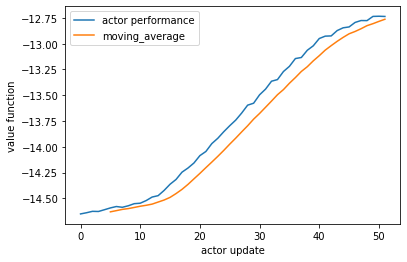

In [41]:
m = 5
plt.plot(rs, label='actor performance')
plt.plot(range(m, len(rs)), moving_average(rs,m), label='moving_average')
plt.xlabel('actor update')
plt.ylabel('value function')
plt.legend()